In [174]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from scipy.stats import norm, ttest_ind

import warnings
from IPython.display import display, Math, Latex
warnings.filterwarnings('ignore')

mpl.rcParams["mathtext.fontset"] = "cm"

df = pd.read_csv("../malberta-runs.csv")
df = df[df['State'] == 'finished']
pretrained = df[df['Tags'].str.contains("pretrain-experiment", regex=False, na=False, case=False)]
base = df[df['Tags'].isnull()]

# Evaluation Accuracy Histogram

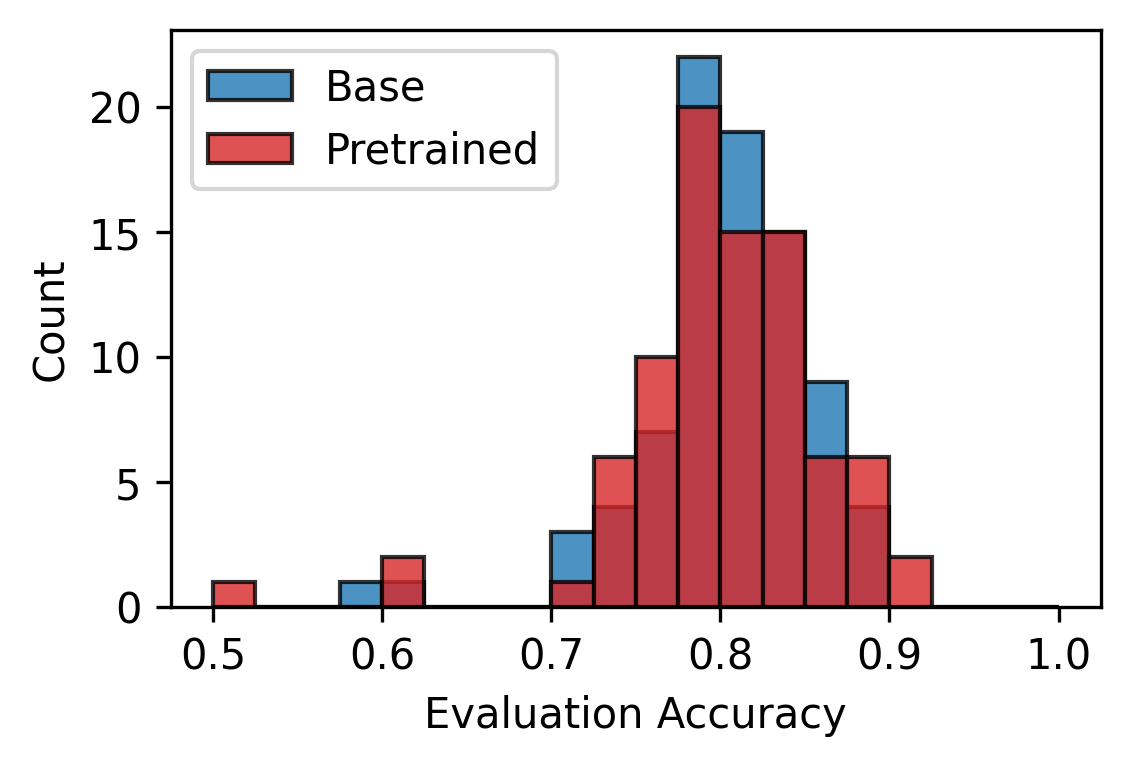

In [149]:
bins = 20

fig, axs = plt.subplots(1, 1, dpi=300, figsize=(4,2.5))

axs.hist(
    base["eval/accuracy"],
    label="Base",
    alpha=0.8,
    edgecolor='k',
    range=(0.5,1),
    bins=bins,
    color='tab:blue'
)
axs.hist(
    pretrained["eval/accuracy"],
    label="Pretrained",
    alpha=0.8,
    edgecolor='k',
    range=(0.5,1),
    bins=bins,
    color='tab:red'
)
axs.set_xlabel("Evaluation Accuracy")
axs.set_ylabel("Count")
plt.legend()

fig.show()

# Classification Metrics

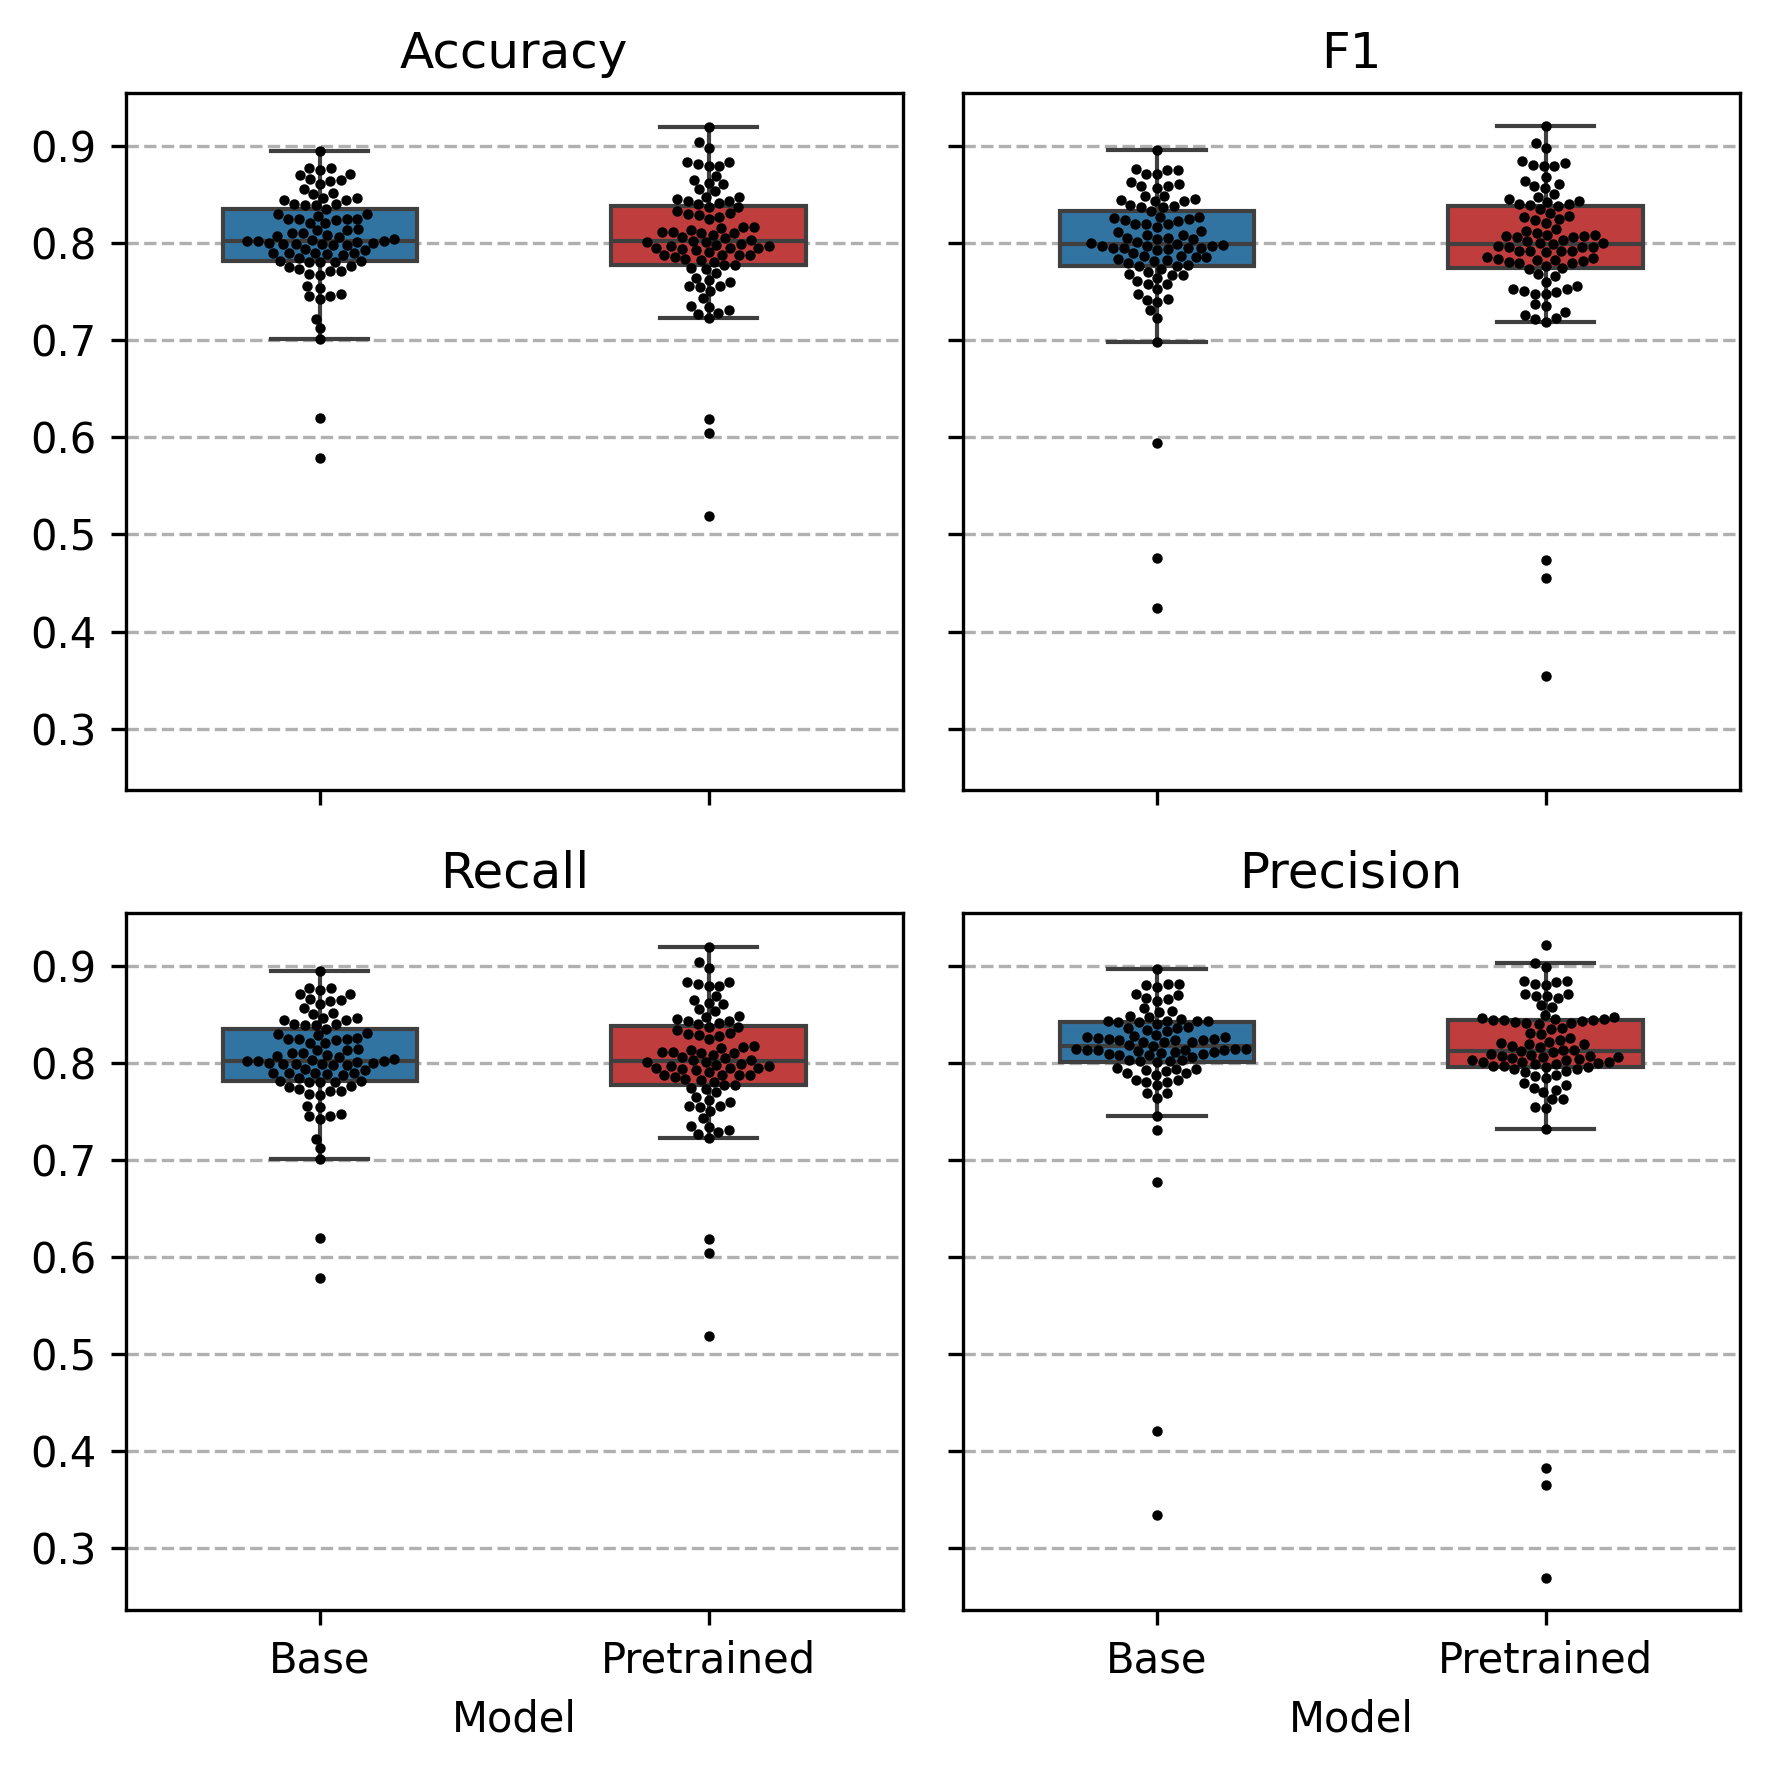

In [150]:
tmp_df = pd.DataFrame(data={
    "Model": ["Base"] * len(base) + ['Pretrained'] * len(pretrained),
    "Accuracy": np.concat([base['eval/accuracy'], pretrained['eval/accuracy']]),
    "F1": np.concat([base['eval/f1'], pretrained['eval/f1']]),
    "Recall": np.concat([base['eval/recall'], pretrained['eval/recall']]),
    "Precision": np.concat([base['eval/precision'], pretrained['eval/precision']]),
})

fig, axs = plt.subplots(2, 2, dpi=300, figsize=(6,6), sharey=True, sharex=True)
fig.set_tight_layout(True)

for ax, metric in zip(axs.flatten(), ["Accuracy", "F1", "Recall", "Precision"]):
    ax.title.set_text(metric)
    sns.boxplot(tmp_df, x='Model', y=metric, palette=['tab:blue', 'tab:red'], width=0.5, fliersize=0, ax=ax).set(ylabel=None)
    sns.swarmplot(tmp_df, x='Model', y=metric, c='k', size=2.5, ax=ax, rasterized=True).set(ylabel=None)
    ax.grid(visible=True, axis='y', linestyle='--')
plt.show()

# Difference in Classification Accuracy Between Base and Pre-trained Models

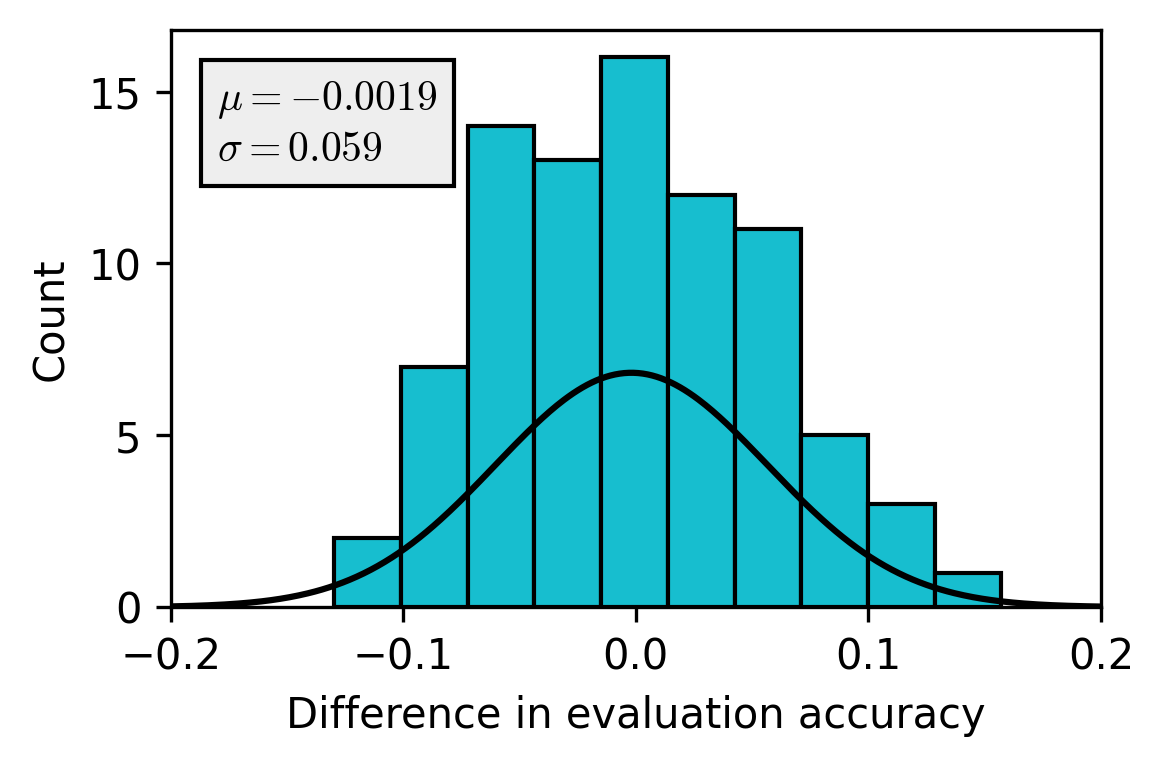

In [157]:
deltas = []
for row in base.itertuples():
    pt = pretrained[pretrained['Notes'] == f'"Pretrained {row.ID}"']
    if pt.empty: 
        continue

    dA = pt['eval/accuracy'] - row._8
    deltas.append(dA)

deltas = np.array(deltas)
mu_d = deltas.mean()
std_d = deltas.std()
x = np.arange(-0.2, 0.2, 0.001)
pdf = norm.pdf(x, mu_d, std_d)

fig, ax = plt.subplots(1,1, dpi=300, figsize=(4,2.5))
ax.set_xlim((-0.2, 0.2))
ax.plot(x, pdf, c='k')
ax.hist(deltas, edgecolor='k', density=False, bins=10, color='tab:cyan')
ax.text(
    -0.18,
    13, 
    rf"$\mu = {mu_d:.2}$" 
    "\n"
    rf"$\sigma = {std_d:.2}$",
    bbox={
        'facecolor': '#eee', 
    }
)
ax.set_xlabel("Difference in evaluation accuracy")
ax.set_ylabel("Count")
ax.set_yticks([0, 5, 10, 15])
fig.show()

# T-Test 

In [179]:
# Null hypothesis is that base models are equal or better than pretrained models 
# Alternative hypothesis is that pretrained models are better than base models 

base_eval = base["eval/accuracy"]
pretrained_eval = pretrained["eval/accuracy"]


t, p = ttest_ind(base_eval, pretrained_eval, alternative='less')

display(Math(rf"t = {t:.2f},~~p = {p:.2f}"))

<IPython.core.display.Math object>